In [1]:
%load_ext autoreload
%autoreload 2

from src.models.SIRM import sweep_pol_SPB_SIRM, sweep_pol_mean_SIRM, sweep_hom_pol_SIRM, sweep_hom_SPB_SIRM
from src.utils.distributions import pol_to_alpha, homogeneous_distribution
from plot_functions import *
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns
import os

path_Plot_with_labels = "../figures/with_labels/"
path_Plot_without_labels = "../figures/no_labels/"

if not os.path.exists(path_Plot_with_labels):
    os.makedirs(path_Plot_with_labels)

if not os.path.exists(path_Plot_without_labels):
    os.makedirs(path_Plot_without_labels)
def ALPHAS(Np):
    return pol_to_alpha(np.linspace(1/Np/2, 1-1/Np/2, Np)/4)



my_hot_r = discretize_cmaps('hot_r', 12)
my_hot_r.set_bad('gray')

my_vir_r = discretize_cmaps('viridis_r', 12)
my_vir_r.set_bad('gray')

In [16]:
# color palettes

CP1 = ['#fdbb84','#fc8d59','#ef6548','#d7301f','#990000']   # POL
CP2 = ['#d9f0a3','#addd8e','#78c679','#31a354','#006837']      # what varies is: MEAN
CP3 = ['#d0d1e6','#a6bddb','#74a9cf','#2b8cbe','#045a8d']      # HOM

In [44]:
NP = 100
NS = 100

susc_max_range={"m": 0.2, "M": 0.6, "n": NS}
pol_range={"m": 0, "M": 1, "n": NP}

results = sweep_pol_SPB_SIRM(
    susc_max_range=susc_max_range,
    pol_range=pol_range,
    h=0,
    dT=1,
    T=1000,
    batch_size=1000,
    N_COMPARTMENTS = 100,
    SPB_exponent=1
)

(S_final, I_final, R_final), R0, OH = results
S = np.sum(S_final, axis=1)
I = np.sum(I_final, axis=1)
R = np.sum(R_final, axis=1)

S = S.reshape(NP, NS).transpose()
I = I.reshape(NP, NS).transpose()
R = R.reshape(NP, NS).transpose()
R0 = R0.reshape(NP, NS).transpose()
OH = OH.reshape(NP, NS).transpose()

FIG_A_RI = R + I
FIG_A_R0 = R0
FIG_A_OH = OH

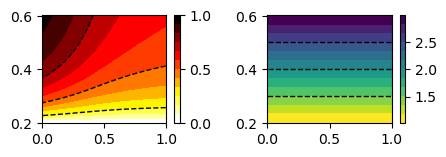

In [45]:
beta_1 = homogeneous_distribution(NS,0.6, 0.2)
pol = homogeneous_distribution(NP,0,1)
name = "I(pol,beta)_SIRB.pdf"

fig, ax = plt.subplots(1,2, figsize=(2*Lx, Ly))

cax = ax[0].imshow(FIG_A_RI, cmap =  my_hot_r, aspect = "auto", origin = "lower", extent = [0,1,0.2,0.6], vmin = 0, vmax = 1)
cbar = fig.colorbar(cax, ax = ax[0])
CS = ax[0].contour(pol, beta_1,np.flipud(FIG_A_RI), levels = [0.25, 0.5, 0.75], linewidths = 1, colors = "black", linestyles = "dashed")

cax = ax[1].imshow(FIG_A_R0, cmap =  my_vir_r, aspect = "auto", origin = "lower", extent = [0,1,0.2,0.6])
cbar = fig.colorbar(cax, ax = ax[1])

CS = ax[1].contour(pol, beta_1,FIG_A_R0, levels = [1, 1.5, 2, 2.5], linewidths = 1, colors = "black", linestyles = "dashed")

fig.tight_layout()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


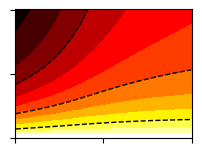

In [46]:
name = "I(pol,beta)_SIRB.pdf"

fig, ax = plt.subplots(figsize=(Lx, Ly))
cax = ax.imshow(FIG_A_RI, cmap =  my_hot_r, aspect = "auto", origin = "lower", extent = [0,1,0.2,0.6], vmin = 0, vmax = 1)
cbar = fig.colorbar(cax, ax = ax)
CS = ax.contour(pol, np.flipud(beta_1),FIG_A_RI, levels = [0.25, 0.5, 0.75], linewidths = 1, colors = "black", linestyles = "dashed")
ax.set_xticks([0,0.5,1])

double_savefig(fig, ax, name, path_Plot_with_labels, path_Plot_without_labels, cbar=cbar)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


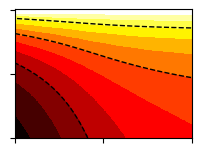

In [69]:
name = "I(pol,beta)_SIRB_V2.pdf"

fig, ax = plt.subplots(figsize=(Lx, Ly))
cax = ax.imshow(np.flipud(FIG_A_RI), cmap =  my_hot_r, aspect = "auto", origin = "lower", extent = [0,1,0.2,0.6], vmin = 0, vmax = 1)
cbar = fig.colorbar(cax, ax = ax)
CS = ax.contour(pol, np.flipud(beta_1),np.flipud(FIG_A_RI), levels = [0.25, 0.5, 0.75], linewidths = 1, colors = "black", linestyles = "dashed")
ax.set_xticks([0,0.5,1])
#CS = ax.contour(pol*4, beta_1,FIG_A_R0, levels = [1.5, 2, 2.5], linewidths = 0.5, colors = "black")

fig.patch.set_visible(False)
double_savefig(fig, ax, name, path_Plot_with_labels, path_Plot_without_labels, cbar=cbar)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


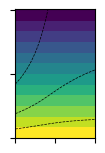

In [86]:
name = "R0(pol,beta)_SIRB.pdf"

fig, ax = plt.subplots(figsize=(Lx/2.2, Ly))
cax = ax.imshow(FIG_A_R0, cmap =  my_vir_r, aspect = "auto", origin = "lower", extent = [0,1,0.2,0.6], vmin = 1, vmax = 3)
cbar = fig.colorbar(cax, ax = ax)
CS = ax.contour(pol, np.flipud(beta_1),FIG_A_RI, levels = [0.25, 0.5, 0.75], linewidths = 0.5, colors = "black", linestyles = "dashed")
ax.set_xticks([0,0.5,1])

fig.patch.set_visible(False)
double_savefig(fig, ax, name, path_Plot_with_labels, path_Plot_without_labels, cbar=cbar)

In [93]:
NP = 100
NS = 1
N_COMPARTMENTS = 100

susc_max_range={"m": 0.5, "M": 0.5, "n": NS}
pol_range={"m": 0, "M": 1, "n": NP}

results = sweep_pol_SPB_SIRM(
    susc_max_range=susc_max_range,
    pol_range=pol_range,
    dT=1,
    T=1000,
    batch_size=1000,
    N_COMPARTMENTS = N_COMPARTMENTS,
    SPB_exponent=1
)

(S_final, I_final, R_final), _, _ = results

S = S_final.reshape(NP, N_COMPARTMENTS).transpose()
I = I_final.reshape(NP, N_COMPARTMENTS).transpose()
R = R_final.reshape(NP, N_COMPARTMENTS).transpose()

Sf = np.zeros((N_COMPARTMENTS, NP))
If = np.zeros((N_COMPARTMENTS, NP))
Rf = np.zeros((N_COMPARTMENTS, NP))
for i in range(NP):

    N_i = S_final[i,:] + I_final[i,:] + R_final[i,:]
    Sf[:,i] = S_final[i,:]/N_i
    If[:,i] = I_final[i,:]/N_i
    Rf[:,i] = R_final[i,:]/N_i

# normalize them: N_i = S

RI = Rf + If


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


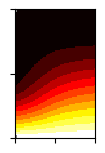

In [94]:
name = "RI_fraction_SIRM.pdf"
fig, ax = plt.subplots(figsize=(Lx/2.2, Ly))
cax = ax.imshow(np.flipud(RI), cmap =  my_hot_r, aspect = "auto", origin = "lower", extent = [0,1,0,1], vmin = 0, vmax = 1, interpolation = "none")
cbar = fig.colorbar(cax, ax = ax)
ax.set_xticks([0,0.5,1])
ax.set_yticks([0,0.5,1])

fig.patch.set_visible(False)
double_savefig(fig, ax, name, path_Plot_with_labels, path_Plot_without_labels, cbar=cbar)

In [51]:
NP = 100  # number of polarization points
NM = 100  # number of mean points
pol_range={"m": 0, "M": 1, "n": NP}  # polarization range
mean_range={"m": 0.0, "M": 1.0, "n": NM}         # mean range
    
results = sweep_pol_mean_SIRM(
    mean_range=mean_range,
    pol_range=pol_range,
    h=0,
    dT=1,
    T=1000,
    susceptibility_rate=0.5,  # This replaces the susceptibility range
    batch_size=1000,
    SPB_exponent=1
)

(S_final, I_final, R_final), R0, OH = results
S = np.sum(S_final, axis=1)
I = np.sum(I_final, axis=1)
R = np.sum(R_final, axis=1)

# Reshape arrays
S = np.flipud(S.reshape(NP, NM))
I = np.flipud(I.reshape(NP, NM))
R = np.flipud(R.reshape(NP, NM))
R0 = np.flipud(R0.reshape(NP, NM))
OH = np.flipud(OH.reshape(NP, NM))

FIG_B_RI = np.flipud(R + I)
FIG_B_R0 = np.flipud(R0)
FIG_B_OH = np.flipud(OH)

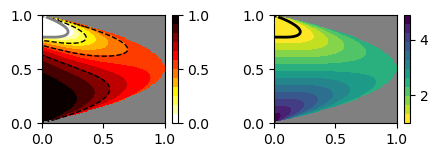

In [52]:
# Create axis values
mean_vals = homogeneous_distribution(NM, 0, 1)
pol = homogeneous_distribution(NP, 0, 1)

# Plotting
fig, ax = plt.subplots(1,2, figsize=(2*Lx, Ly))

cax = ax[0].imshow(FIG_B_RI,  cmap=my_hot_r,  aspect="auto", origin="lower", 
    extent=[0, 1, 0, 1],  # Note: changed to [0,1,0,1] since both axes are now in [0,1]
    vmin=0, vmax=1)
cbar = fig.colorbar(cax, ax=ax[0])

CS = ax[0].contour(pol, mean_vals, FIG_B_RI, 
    levels=[0.25, 0.5, 0.75], linewidths=1, 
    colors="black", linestyles="dashed")

cax = ax[1].imshow(FIG_B_R0, cmap=my_vir_r, aspect="auto", origin="lower",
    extent=[0, 1, 0, 1], vmin = 1)  # Note: changed to [0,1,0,1] since both axes are now in [0,1]
cbar = fig.colorbar(cax, ax=ax[1])
CS = ax[1].contour(pol, mean_vals, FIG_B_R0, 
    levels=[1], linewidths=2, 
    colors="black")
CS = ax[0].contour(pol, mean_vals, FIG_B_R0, 
    levels=[1], linewidths=2, 
    colors="gray")

fig.tight_layout()

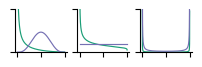

In [196]:
from src.utils.distributions import pol_mean_to_ab
from scipy.stats import beta
import numpy as np

LW = 0.85

def betadistr(a,b, nx = 1000):
    x = np.linspace(1/nx/2, 1-1/nx/2, nx)
    return x, beta.pdf(x, a, b)

def clean(ax):
    ax.spines[['top','right']].set_visible(False)
    ax.set_xticks([0, 0.5, 1])
    ax.set_yticks([0, 5, 10])
    ax.set_ylim(0, 5)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

fig, ax = plt.subplots(1,3, figsize=(Lx, Ly/3))


a,b =pol_mean_to_ab(0.1, 0.1)
x,y = betadistr(a,b)
ax[0].plot(x, y, color = "#1b9e77", linewidth = LW)

a,b = pol_mean_to_ab(0.1, 0.5)
x,y = betadistr(a,b)
ax[0].plot(x, y, color = "#7570b3", linewidth = LW)
clean(ax[0])
##################
a,b = pol_mean_to_ab(1/3, 0.35)
x,y = betadistr(a,b)
ax[1].plot(x, y, color = "#1b9e77", linewidth = LW)

a,b = pol_mean_to_ab(1/3, 0.5)
x,y = betadistr(a,b)
ax[1].plot(x, y, color = "#7570b3", linewidth = LW)
clean(ax[1])
########

a,b = pol_mean_to_ab(0.9, 0.35)
x,y = betadistr(a,b)
ax[2].plot(x, y, color = "#1b9e77", linewidth = LW)

a,b = pol_mean_to_ab(0.9, 0.5)
x,y = betadistr(a,b)
ax[2].plot(x, y, color = "#7570b3", linewidth = LW)
clean(ax[2])


fig.patch.set_visible(False)

name = "beta_distributions.pdf"
plt.savefig(path_Plot_with_labels + name, bbox_inches='tight')
plt.savefig(path_Plot_without_labels + name, bbox_inches='tight')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


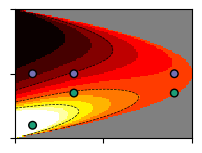

In [224]:
col_pol_circles = ["#1b9e77", "#7570b3"]
name = "SIRB_B(m,p)_RI.pdf"

fig, ax = plt.subplots(figsize=(Lx, Ly))
cax = ax.imshow(np.flipud(FIG_B_RI), cmap=my_hot_r, aspect="auto", origin="lower", extent=[0, 1, 0, 1], vmin=0, vmax=1, interpolation="none")
cbar = fig.colorbar(cax, ax=ax)
#CS = ax.contour(h_vals, pol*4, FIG_C_RI, levels=[0.25, 0.5, 0.75], linewidths=1, colors="black", linestyles="dashed")
CS = ax.contour(pol, mean_vals, np.flipud(FIG_B_RI), 
    levels=[0.25, 0.5, 0.75], linewidths=0.5, 
    colors="black", linestyles="dashed")
Xs = np.array([0.1, 0.3, 0.5, 0.7, 0.9])
Ys = np.zeros(5)+0.001

#ax.plot(1-Xs, 1-Ys, 'o', color='black', markersize=1)
#ax.plot(1-Ys, 1-Xs, 'o', color='black', markersize=1)

Xs = np.array([0.1, 0.1, 1/3, 1/3, 0.9, 0.9])
Ys = np.array([0.1, 0.5, 0.35, 0.5, 0.35, 0.5])
Colors = [col_pol_circles[0], col_pol_circles[1],col_pol_circles[0], col_pol_circles[1],col_pol_circles[0], col_pol_circles[1]]

ax.scatter(Xs, Ys, c=Colors, marker='o', s=30, zorder = 100,edgecolors='black')

ax.set_xticks([0,0.5,1])
ax.set_yticks([0,0.5,1])



fig.patch.set_visible(False)
double_savefig(fig, ax, name, path_Plot_with_labels, path_Plot_without_labels, cbar=cbar)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


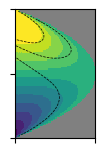

In [217]:
name = "SIRB_B(m,p)_R0.pdf"

fig, ax = plt.subplots(figsize=(Lx/2.2, Ly))
cax = ax.imshow(FIG_B_R0, cmap=my_vir_r, aspect="auto", origin="lower", extent=[0, 1, 0, 1], vmin = 1, vmax = 5, interpolation="none")
cbar = fig.colorbar(cax, ax=ax)
#CS = ax.contour(h_vals, pol*4, FIG_C_RI, levels=[0.25, 0.5, 0.75], linewidths=1, colors="black", linestyles="dashed")
CS = ax.contour(pol, mean_vals, FIG_B_RI, 
    levels=[0.25, 0.5, 0.75], linewidths=0.5, 
    colors="black", linestyles="dashed")

ax.set_xticks([0,1])
ax.set_yticks([0,0.5,1])

fig.patch.set_visible(False)
double_savefig(fig, ax, name, path_Plot_with_labels, path_Plot_without_labels, cbar=cbar)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[0.1        0.29999998 0.5        0.6999999  0.9       ]


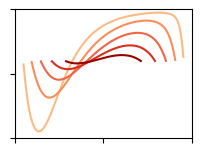

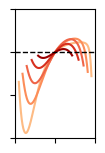

In [17]:
NP = 5  # number of polarization points
NM = 500  # number of mean points
pol_range={"m": 0.1, "M": 0.9, "n": NP} 
mean_range={"m": 0.0, "M": 1.0, "n": NM}         

pols = homogeneous_distribution(NP, 0, 1)
means = homogeneous_distribution(NM, 0, 1)

#results = run_pol_mean_sweep_SIRT(
results = sweep_pol_mean_SIRM(
    mean_range=mean_range,
    pol_range=pol_range,
    h=0,
    dT=1,
    T=1000,
    susceptibility_rate=0.6,  # This replaces the susceptibility range
    batch_size=1000,
    N_COMPARTMENTS = 100,
    SPB_exponent=1
)
(S_final, I_final, R_final), R0, OH = results

S = np.sum(S_final, axis=1)
I = np.sum(I_final, axis=1)
R = np.sum(R_final, axis=1)

# Correct reshaping
S = S.reshape(NM, NP).T  # Shape becomes (NP, NM)
I = I.reshape(NM, NP).T
R = R.reshape(NM, NP).T
R0 = R0.reshape(NM, NP).T
OH = OH.reshape(NM, NP).T

temp = np.fliplr(R + I)


# Plot each polarization value
fig, ax = plt.subplots(figsize=(Lx, Ly))
for i in range(NP):
    ax.plot(means,(temp[i, :]), color = CP1[i])

ax.set_ylim(0, 1)
ax.set_xlim(0, 1)

name = "SIRB_B(m)_RI.pdf"
ax.set_xticks([0, 0.5, 1])
ax.set_yticks([0, 0.5, 1])

double_savefig(fig, ax, name, path_Plot_with_labels, path_Plot_without_labels)

# find the index of the closest value to 0.5
idx = (np.abs(means - 0.5)).argmin()

fig, ax = plt.subplots(figsize=(Lx/2.2, Ly))
for i in range(NP):
    ax.plot(means, (temp[i, :]-temp[i, idx])/temp[i, idx]*100, color = CP1[i])

# Add a horizontal line at 0
ax.axhline(0, color='black', lw=1, ls='--')

ax.set_ylim(-100, 50)
ax.set_xlim(0, 1)

name = "SIRB_B(m)_RI100.pdf"
ax.set_xticks([0, 0.5, 1])
ax.set_yticks([-100, -50, 0, 50])

fig.patch.set_visible(False)
double_savefig(fig, ax, name, path_Plot_with_labels, path_Plot_without_labels)

print(pols)



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[0.1        0.29999998 0.5        0.6999999  0.9       ]


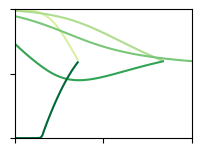

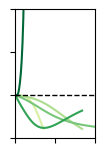

In [18]:
NP = 100    # number of polarization points
NM = 5      # number of mean points
pol_range={"m": 0, "M": 1, "n": NP}  
mean_range={"m": 0, "M": 1, "n": NM}         

pols = homogeneous_distribution(NP, 0, 1)
means = homogeneous_distribution(NM, 0, 1)

#results = run_pol_mean_sweep_SIRT(
results = sweep_pol_mean_SIRM(
    mean_range=mean_range,
    pol_range=pol_range,
    h=0,
    dT=1,
    T=1000,
    susceptibility_rate=0.6,  # This replaces the susceptibility range
    batch_size=1000,
    N_COMPARTMENTS = 100,
    SPB_exponent=1
)
(S_final, I_final, R_final), R0, OH = results

S = np.sum(S_final, axis=1)
I = np.sum(I_final, axis=1)
R = np.sum(R_final, axis=1)

# Correct reshaping
S = S.reshape(NM, NP).T  # Shape becomes (NP, NM)
I = I.reshape(NM, NP).T
R = R.reshape(NM, NP).T
R0 = R0.reshape(NM, NP).T
OH = OH.reshape(NM, NP).T

temp = R + I

# Plot each polarization value
fig, ax = plt.subplots(figsize=(Lx, Ly))
for i in range(NM):
    ax.plot(pols, temp[:,i], color = CP2[i])

ax.set_ylim(0, 1)
ax.set_xlim(0, 1)
ax.set_xticks([0, 0.5, 1])
ax.set_yticks([0, 0.5, 1])
name = "SIRB_B(p)_RI.pdf"

fig.patch.set_visible(False)
double_savefig(fig, ax, name, path_Plot_with_labels, path_Plot_without_labels)

fig, ax = plt.subplots(figsize=(Lx/2.2, Ly))
for i in range(NM):
    ax.plot(pols, (temp[:,i]-temp[0,i])/temp[0,i]*100, color = CP2[i])

# Add a horizontal line at 0
ax.axhline(0, color='black', lw=1, ls='--')

ax.set_ylim(-50, 100)

ax.set_xlim(0, 1)
ax.set_xticks([0, 0.5, 1])
ax.set_yticks([-50, 0, 50, 100])
name = "SIRB_B(p)_RI100.pdf"

fig.patch.set_visible(False)
double_savefig(fig, ax, name, path_Plot_with_labels, path_Plot_without_labels)

print(means)

0.6054999999999999 1.1245000000000003
1.0000000000000002 1.0


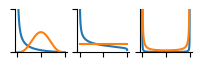

In [225]:
NP = 100  # number of polarization points
NH = 100  # number of homophily points
h_range={"m": -10.0, "M": 10.0, "n": NH}
pol_range ={"m": 0, "M": 1, "n": NP}
results = sweep_hom_pol_SIRM(
    h_range=h_range,     # homophily range
    pol_range=pol_range,  # polarization range
    dT=1,
    T=1000,
    recovery_rate=0.1,
    susceptibility_rate=0.35,  
    batch_size=1000
)

(S_final, I_final, R_final), R0, OH = results
S = np.sum(S_final, axis=1)
I = np.sum(I_final, axis=1)
R = np.sum(R_final, axis=1)

# Reshape arrays
S = S.reshape(NP, NH)  # No transpose needed
I = I.reshape(NP, NH)
R = R.reshape(NP, NH)
R0 = R0.reshape(NP, NH)
OH = OH.reshape(NP, NH)

FIG_C_RI = R + I
FIG_C_R0 = R0
FIG_C_OH = OH

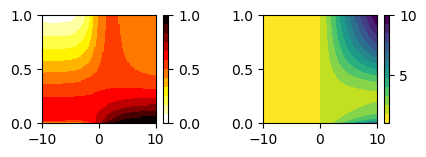

In [226]:
h_vals = homogeneous_distribution(NH, h_range["m"], h_range["M"])
pol = homogeneous_distribution(NP, 0, 1)

# Plotting

fig, ax = plt.subplots(1,2, figsize=(2*Lx, Ly))

cax = ax[0].imshow(FIG_C_RI, cmap=my_hot_r, aspect="auto", origin="lower", 
    extent=[h_range["m"], h_range["M"], 0, 1],  # Note: changed extent to match h and pol ranges
    vmin=0, vmax=1, interpolation="none")
cbar = fig.colorbar(cax, ax=ax[0])

cax = ax[1].imshow(FIG_C_R0, cmap=my_vir_r, aspect="auto", origin="lower",
    extent=[h_range["m"], h_range["M"], 0, 1],  # Note: changed extent to match h and pol ranges
    vmin=1, vmax = 10)
cbar = fig.colorbar(cax, ax=ax[1])

CS = ax[1].contour(h_vals, pol, FIG_C_R0,  # Note: transpose to match the expected orientation
    levels=[1], linewidths=2, colors="black")
CS = ax[0].contour(h_vals, pol, FIG_C_R0,  # Note: transpose to match the expected orientation
    levels=[1], linewidths=2, colors="black")



fig.tight_layout()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


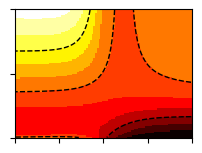

In [237]:
name = "SIRB_(h,p)_RI.pdf"

fig, ax = plt.subplots(figsize=(Lx, Ly))
cax = ax.imshow(FIG_C_RI, cmap=my_hot_r, aspect="auto", origin="lower", extent=[-10, 10, 0, 1], vmin=0, vmax=1, interpolation="none")
cbar = fig.colorbar(cax, ax=ax)
CS = ax.contour(h_vals, pol, FIG_C_RI, levels=[0.25, 0.5, 0.75], linewidths=1, colors="black", linestyles="dashed")
CS = ax.contour(h_vals, pol, FIG_C_R0, levels=[1], linewidths=2, colors="gray")

ax.set_xticks([-10, -5, 0, 5, 10])
ax.set_yticks([0, 0.5, 1])

fig.patch.set_visible(False)
double_savefig(fig, ax, name, path_Plot_with_labels, path_Plot_without_labels, cbar=cbar)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


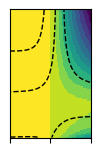

: 

In [ ]:
name = "SIRB_(h,p)_R0.pdf"

fig, ax = plt.subplots(figsize=(Lx/2.2, Ly))
cax = ax.imshow(FIG_C_R0, cmap=my_vir_r, aspect="auto", origin="lower", extent=[-10, 10, 0, 1], vmin=1, vmax=10, interpolation="none")
cbar = fig.colorbar(cax, ax=ax)
CS = ax.contour(h_vals, pol, FIG_C_RI, levels=[0.25, 0.5, 0.75], linewidths=1, colors="black", linestyles="dashed")
CS = ax.contour(h_vals, pol, FIG_C_R0, levels=[1], linewidths=2, colors="gray")

ax.set_xticks([-10, 0,  10])
ax.set_yticks([])
fig.patch.set_visible(False)
double_savefig(fig, ax, name, path_Plot_with_labels, path_Plot_without_labels, cbar=cbar)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


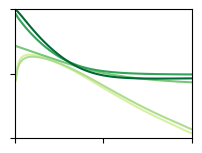

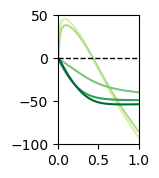

In [21]:
NP = 100  # number of polarization points
NH = 5  # number of homophily points

h_range={"m": -10.0, "M": 10.0, "n": NH}
pol_range = {"m": 0, "M": 1, "n": NP}
pols = homogeneous_distribution(NP, 0, 1)

results = sweep_hom_pol_SIRM(
    h_range=h_range,     # homophily range
    pol_range=pol_range,  # polarization range
    dT=1,
    T=1000,
    recovery_rate=0.1,
    susceptibility_rate=0.35,  
    batch_size=1000
)

(S_final, I_final, R_final), R0, OH = results
S = np.sum(S_final, axis=1)
I = np.sum(I_final, axis=1)
R = np.sum(R_final, axis=1)

# Reshape arrays
S = S.reshape(NP, NH)  # No transpose needed
I = I.reshape(NP, NH)
R = R.reshape(NP, NH)
R0 = R0.reshape(NP, NH)
OH = OH.reshape(NP, NH)

temp = R + I

# Plot each polarization value
fig, ax = plt.subplots(figsize=(Lx, Ly))
for i in range(NH):
    ax.plot(pols, temp[:, i], color = CP2[i])

ax.set_ylim(0, 1)
ax.set_xlim(0, 1)
ax.set_xticks([0, 0.5, 1])
ax.set_yticks([0, 0.5, 1])

name = "SIRB_C_(p)_RI.pdf"

fig.patch.set_visible(False)
double_savefig(fig, ax, name, path_Plot_with_labels, path_Plot_without_labels)

fig, ax = plt.subplots(figsize=(Lx/2.2, Ly))
for i in range(NH):
    ax.plot(pols, (temp[:,i]-temp[0,i])/temp[0,i]*100, color = CP2[i])

# Add a horizontal line at 0
ax.axhline(0, color='black', lw=1, ls='--')

ax.set_ylim(-100, 50)
ax.set_xlim(0, 1)
ax.set_xticks([0, 0.5, 1])
ax.set_yticks([-100, -50, 0, 50])

name = "SIRB_C_(p)_RI100.pdf"

fig.patch.set_visible(False)
#double_savefig(fig, ax, name, path_Plot_with_labels, path_Plot_without_labels)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


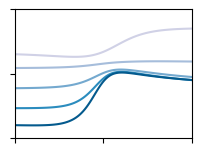

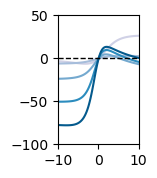

In [20]:
NP = 5  # number of polarization points
NH = 100  # number of homophily points



h_range={"m": -10.0, "M": 10.0, "n": NH}
pol_range = {"m": 0, "M": 1, "n": NP}
pols = homogeneous_distribution(NP, 0, 1)
homs = homogeneous_distribution(NH, h_range['m'], h_range['M'])
results = sweep_hom_pol_SIRM(
    h_range=h_range,     # homophily range
    pol_range=pol_range,  # polarization range
    dT=1,
    T=1000,
    recovery_rate=0.1,
    susceptibility_rate=0.35,  
    batch_size=1000
)

(S_final, I_final, R_final), R0, OH = results
S = np.sum(S_final, axis=1)
I = np.sum(I_final, axis=1)
R = np.sum(R_final, axis=1)

# Reshape arrays
S = S.reshape(NP, NH)  # No transpose needed
I = I.reshape(NP, NH)
R = R.reshape(NP, NH)
R0 = R0.reshape(NP, NH)
OH = OH.reshape(NP, NH)

temp = R + I

# Plot each polarization value
fig, ax = plt.subplots(figsize=(Lx, Ly))
for i in range(NP):
    ax.plot(homs, temp[i, :], color = CP3[i])

ax.set_ylim(0, 1)
ax.set_xlim(-10, 10)
ax.set_xticks([-10, 0, 10])
ax.set_yticks([0, 0.5, 1])

name = "SIRB_C_(h)_RI.pdf"

fig.patch.set_visible(False)
double_savefig(fig, ax, name, path_Plot_with_labels, path_Plot_without_labels)


# find the index of homs closest value to 0
idx = (np.abs(homs - 0)).argmin()

fig, ax = plt.subplots(figsize=(Lx/2.2, Ly))
for i in range(NP):
    ax.plot(homs, (temp[i,:]-temp[i,idx])/temp[i,idx]*100, color = CP3[i])

# Add a horizontal line at 0
ax.axhline(0, color='black', lw=1, ls='--')
ax.set_xlim(-10, 10)
ax.set_ylim(-100, 50)

ax.set_xticks([-10, 0, 10])
ax.set_yticks([-100, -50, 0, 50])

name = "SIRB_C_(h)_RI100.pdf"

fig.patch.set_visible(False)
#double_savefig(fig, ax, name, path_Plot_with_labels, path_Plot_without_labels)

In [234]:
from src.utils.Contact_Matrix import create_contact_matrix
from jax import numpy as jnp

Cm10 = create_contact_matrix(100, -10, jnp.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]))
Cm5 = create_contact_matrix(100, -5, jnp.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]))
Cm25 = create_contact_matrix(100, -2.5, jnp.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]))
C0 = create_contact_matrix(100, 0, jnp.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]))
Cp25 = create_contact_matrix(100, 2.5, jnp.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]))
Cp5 = create_contact_matrix(100, 5, jnp.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]))
Cp10 = create_contact_matrix(100, 10, jnp.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]))

names = ["Cm10", "Cm5", "C0", "Cp5", "Cp10"]
titles = ["h = -10", "h = -5",  "h = 0",  "h = 5", "h = 10"]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


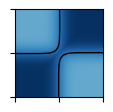

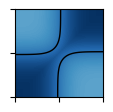

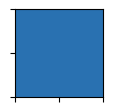

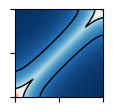

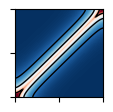

In [236]:
for i in range(5):
    fig, ax = plt.subplots(figsize=(Lx/2, Lx/2))
    cax = ax.imshow(eval(names[i]), cmap="RdBu_r", aspect="auto", origin="lower", vmin=0, vmax=8, extent=[0, 1, 0, 1])
    cbar = fig.colorbar(cax, ax=ax)
    CS = ax.contour(jnp.linspace(0,1,100),jnp.linspace(0,1,100), eval(names[i]), levels=[1, 3 , 6], linewidths=1, colors="black")
    ax.set_title(titles[i])
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    name = names[i] + ".pdf"
    fig.patch.set_visible(False)
    double_savefig(fig, ax, name, path_Plot_with_labels, path_Plot_without_labels, cbar=cbar)



In [232]:
import matplotlib.pyplot as plt
import matplotlib as mpl

fig = plt.figure(figsize=(Lx*4, 0.1))

# Remove all margins and padding
fig.patch.set_visible(False)

# Create an invisible axes with zero size
ax = fig.add_axes([0, 0, 0, 0])
ax.set_visible(False)

# Create the colorbar axes explicitly
cbar_ax = fig.add_axes([0.1, 0.1, 0.2, 0.8])  # [left, bottom, width, height]

# Create the colorbar using your original mappable
norm = mpl.colors.Normalize(vmin=0, vmax=1)
sm = plt.cm.ScalarMappable(cmap='RdBu_r', norm=norm)
sm.set_array([])

cbar = plt.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cbar.set_ticks([0, 0.5, 1])
cbar.set_ticklabels([])

name = "CM_colorbar.pdf"
fig.savefig(path_Plot_with_labels + name, bbox_inches='tight')
fig.savefig(path_Plot_without_labels + name, bbox_inches='tight')

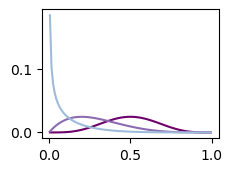

In [127]:
# generate beta distributions:

from scipy.stats import beta
import numpy as np
import matplotlib.pyplot as plt
a, b = 5, 5
x = np.linspace(1/100/2, 1-1/100/2, 100)
y = beta.pdf(x, a, b)
y5 = y/np.sum(y)

a, b = 2, 5
y = beta.pdf(x, a, b)
y1 = y/np.sum(y)

a, b = 0.5, 5
y = beta.pdf(x, a, b)
y05 = y/np.sum(y)

fig, ax = plt.subplots(figsize=(Lx, Ly))
ax.plot(x, y5, label="a=5, b=5", color = "#6e016b")
ax.plot(x, y1, label="a=1, b=1", color = "#8c6bb1")
ax.plot(x, y05, label="a=0.5, b=0.5", color = "#9ebcda")